<a href="https://www.kaggle.com/code/elijahnyasiando/creditriskmodel-me-fa-xgboost-gpu-accelaration?scriptVersionId=290314402" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Modules

In [1]:
import warnings
# warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error,r2_score, precision_recall_curve
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor


from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, make_scorer
from statsmodels.distributions.empirical_distribution import ECDF


# Set some display options for better viewing
pd.set_option('display.max_columns', 50)
sns.set_style('whitegrid')

# Creating Master Training Dataset

In [2]:
COHORTS = ['2018Q1','2018Q2','2018Q3','2018Q4', '2019Q1', '2019Q2', '2019Q3', '2019Q4']

ORIGINATION_COL_NAMES = [
    'CREDIT_SCORE', 'FIRST_PAYMENT_DATE', 'FIRST_TIME_HOMEBUYER_FLAG',
    'MATURITY_DATE', 'METROPOLITAN_STATISTICAL_AREA',
    'MORTGAGE_INSURANCE_PERCENTAGE', 'NUMBER_OF_UNITS', 'OCCUPANCY_STATUS',
    'ORIGINAL_COMBINED_LOAN_TO_VALUE_CLTV', 'ORIGINAL_DEBT_TO_INCOME_DTI_RATIO',
    'ORIGINAL_UPB', 'ORIGINAL_LOAN_TO_VALUE_LTV', 'ORIGINAL_INTEREST_RATE',
    'CHANNEL', 'PREPAYMENT_PENALTY_MORTGAGE_FLAG', 'AMORTIZATION_TYPE',
    'PROPERTY_STATE', 'PROPERTY_TYPE', 'POSTAL_CODE', 'LOAN_SEQUENCE_NUMBER',
    'LOAN_PURPOSE', 'ORIGINAL_LOAN_TERM', 'NUMBER_OF_BORROWERS', 'SELLER_NAME',
    'SERVICER_NAME', 'SUPER_CONFORMING_FLAG', 'PRE-RELIEF_REFINANCE_LOAN_SEQUENCE_NUMBER',
    'SPECIAL_ELIGIBILITY_PROGRAM', 'RELIEF_REFINANCE_INDICATOR', 'PROPERTY_VALUATION_METHOD',
    'INTEREST_ONLY_INDICATOR', 'MI_CANCELLATION_INDICATOR'
]

PERFORMANCE_COL_NAMES = [
    'LOAN_SEQUENCE_NUMBER', 'MONTHLY_REPORTING_PERIOD', 'CURRENT_ACTUAL_UPB',
    'CURRENT_LOAN_DELINQUENCY_STATUS', 'LOAN_AGE', 'REMAINING_MONTHS_TO_LEGAL_MATURITY',
    'DEFECT_SETTLEMENT_DATE', 'MODIFICATION_FLAG', 'ZERO_BALANCE_CODE',
    'ZERO_BALANCE_EFFECTIVE_DATE', 'CURRENT_INTEREST_RATE', 'CURRENT_NON-INTEREST_BEARING_UPB',
    'DUE_DATE_OF_LAST_PAID_INSTALLMENT_DDLPI', 'MI_RECOVERIES', 'NET_SALE_PROCEEDS',
    'NON_MI_RECOVERIES', 'TOTAL_EXPENSES', 'LEGAL_COSTS',
    'MAINTENANCE_AND_PRESERVATION_COSTS', 'TAXES_AND_INSURANCE', 'MISCELLANEOUS_EXPENSES',
    'ACTUAL_LOSS_CALCULATION', 'CUMULATIVE_MODIFICATION_COST', 'STEP_MODIFICATION_FLAG',
    'PAYMENT_DEFERRAL', 'ESTIMATED_LOAN_TO_VALUE_ELTV', 'ZERO_BALANCE_REMOVAL_UPB',
    'DELINQUENT_ACCRUED_INTEREST', 'DELINQUENCY_DUE_TO_DISASTER',
    'BORROWER_ASSISTANCE_STATUS_CODE', 'CURRENT_MONTH_MODIFICATION_COST', 'INTEREST_BEARING_UPB'
]

COVARIATES_TO_KEEP = [
    'LOAN_SEQUENCE_NUMBER', 'CREDIT_SCORE', 'ORIGINAL_DEBT_TO_INCOME_DTI_RATIO',
    'ORIGINAL_LOAN_TO_VALUE_LTV', 'ORIGINAL_UPB', 'ORIGINAL_INTEREST_RATE',
    'NUMBER_OF_UNITS', 'NUMBER_OF_BORROWERS', 'LOAN_PURPOSE', 'CHANNEL','FIRST_TIME_HOMEBUYER_FLAG', 'OCCUPANCY_STATUS', 'PROPERTY_TYPE'
]

perf_dtypes = {
    'LOAN_SEQUENCE_NUMBER': 'string',
    'CURRENT_LOAN_DELINQUENCY_STATUS': 'string', # Keep string, handle 'XX'/'R' later
    'ZERO_BALANCE_CODE': 'string'
}

all_cohort_data = []

for cohort in COHORTS:
    print(f"--> Processing cohort: {cohort}...")
    
    # --- OPTIMIZATION: Process Performance Data in Chunks ---
    perf_file_path = f'/kaggle/input/2018-2019-small-loans-data/data/historical_data_time_{cohort}.txt'
    
    chunk_list = []
    # Read in chunks of 1 million rows to prevent OOM
    for chunk in pd.read_csv(perf_file_path, sep='|', header=None, names=PERFORMANCE_COL_NAMES,
                             usecols=['LOAN_SEQUENCE_NUMBER', 'CURRENT_LOAN_DELINQUENCY_STATUS', 'ZERO_BALANCE_CODE'],
                             dtype=perf_dtypes, chunksize=1_000_000):
        
        # Vectorized clean-up within chunk
        chunk['delinq_num'] = pd.to_numeric(chunk['CURRENT_LOAN_DELINQUENCY_STATUS'], errors='coerce').fillna(0)
        
        # Vectorized Flagging
        # Flag 1: Every 90+ DPD
        chunk['is_90plus'] = (chunk['delinq_num'] >= 3)
        # Flag 2: Bad Termination (03=Foreclosure, 09=Deed/Short Sale)
        chunk['is_bad_term'] = chunk['ZERO_BALANCE_CODE'].isin(['03', '09'])
        
        # Group by Loan ID within chunk? NO. Loans span chunks. 
        # We must filter to relevant rows or aggregate partially.
        # STRATEGY: Reduce chunk to only "Bad" events, then aggregate later.
        
        # Filter chunk to only rows that indicate a default event
        bad_events = chunk[(chunk['is_90plus']) | (chunk['is_bad_term'])][['LOAN_SEQUENCE_NUMBER']]
        chunk_list.append(bad_events)

    # Concatenate all "Bad" events found
    all_bad_loans = pd.concat(chunk_list)
    
    # Get unique set of Defaulters
    defaulters_set = set(all_bad_loans['LOAN_SEQUENCE_NUMBER'].unique())
    print(f"    Identified {len(defaulters_set)} unique defaulters in {cohort}.")

    # --- Process Origination Data ---
    print(f"    Reading origination data for {cohort}...")
    orig_file_path = f'/kaggle/input/2018-2019-small-loans-data/data/historical_data_{cohort}.txt'
    
    # Load Origination (Usually fits in memory, but use dtypes to be safe)
    df_orig = pd.read_csv(orig_file_path, sep='|', header=None, names=ORIGINATION_COL_NAMES,
                          usecols=COVARIATES_TO_KEEP, dtype={'LOAN_SEQUENCE_NUMBER': 'string'})

    # --- Map Targets ---
    # 1 if in defaulters_set, else 0
    df_orig['Default_Flag'] = df_orig['LOAN_SEQUENCE_NUMBER'].isin(defaulters_set).astype(int)
    
    all_cohort_data.append(df_orig)

# Final Concatenation
master_training_set = pd.concat(all_cohort_data, ignore_index=True)
master_training_set.to_parquet('master_training_set.parquet', index=False)

print("\nPipeline complete! The file is ready for your modeling notebook.")



--> Processing cohort: 2018Q1...
    Identified 16098 unique defaulters in 2018Q1.
    Reading origination data for 2018Q1...
--> Processing cohort: 2018Q2...
    Identified 19182 unique defaulters in 2018Q2.
    Reading origination data for 2018Q2...
--> Processing cohort: 2018Q3...
    Identified 18069 unique defaulters in 2018Q3.
    Reading origination data for 2018Q3...
--> Processing cohort: 2018Q4...
    Identified 15083 unique defaulters in 2018Q4.
    Reading origination data for 2018Q4...
--> Processing cohort: 2019Q1...
    Identified 14659 unique defaulters in 2019Q1.
    Reading origination data for 2019Q1...
--> Processing cohort: 2019Q2...
    Identified 1949 unique defaulters in 2019Q2.
    Reading origination data for 2019Q2...
--> Processing cohort: 2019Q3...
    Identified 27690 unique defaulters in 2019Q3.
    Reading origination data for 2019Q3...
--> Processing cohort: 2019Q4...
    Identified 27975 unique defaulters in 2019Q4.
    Reading origination data for 201

 # Exploratory Data Analysis (EDA)
 Initial Overview

--> Loading dataset from master_training_set.parquet...
    Cleaning Credit Scores...
    Data Cleaned. Rows remaining: 3065411

--> 1. Checking Monotonicity (Risk Banding)...


/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


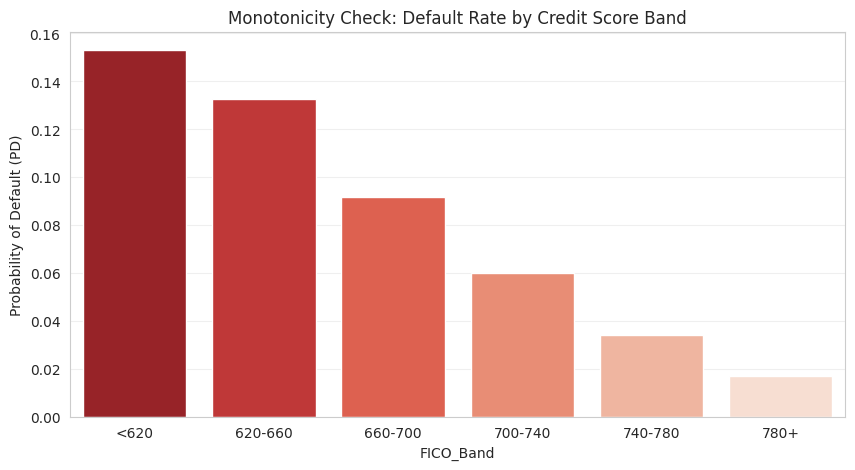

    *Architect Note*: If the bars do not descend like a staircase, the model will be unstable.

--> 2. Visualizing Non-Linear Risk Cliffs (Capacity & Collateral)...


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

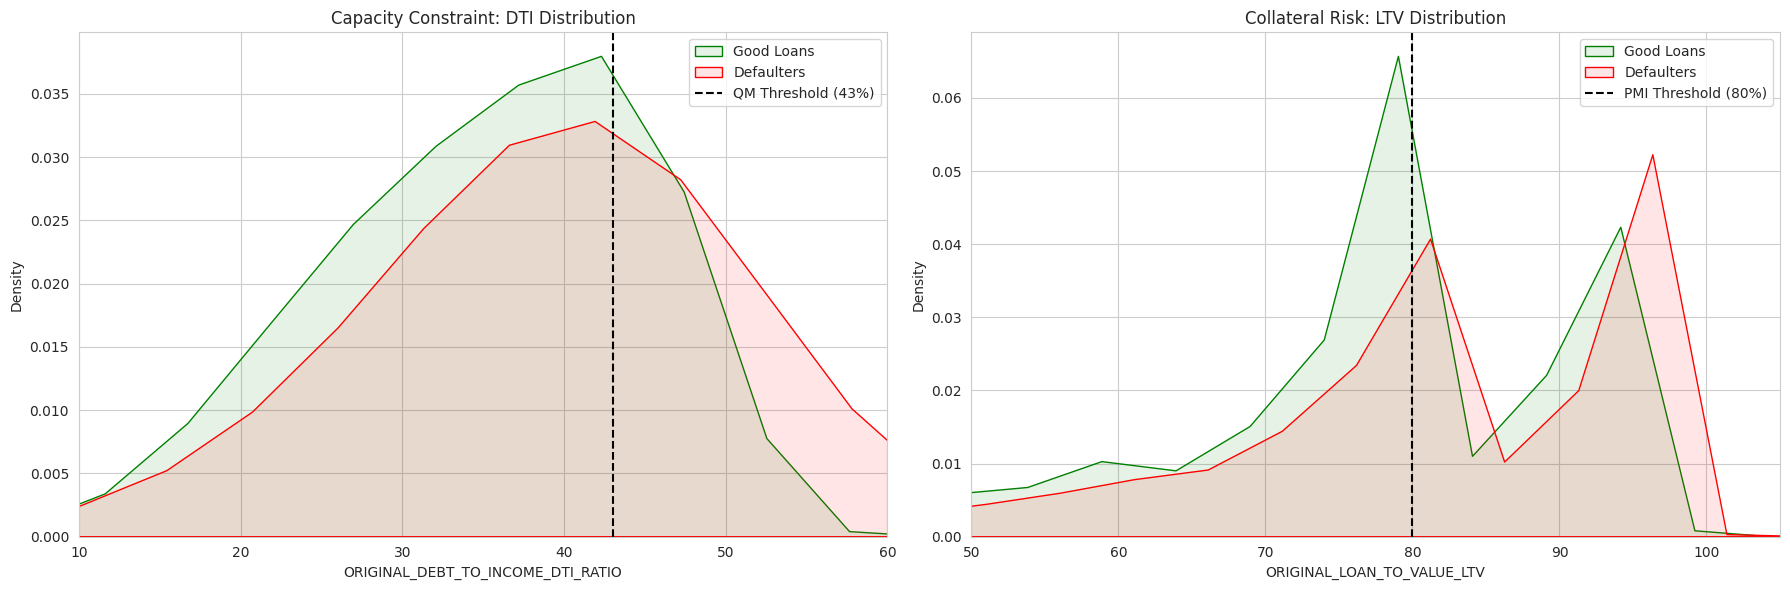


--> 3. Correlation Matrix...


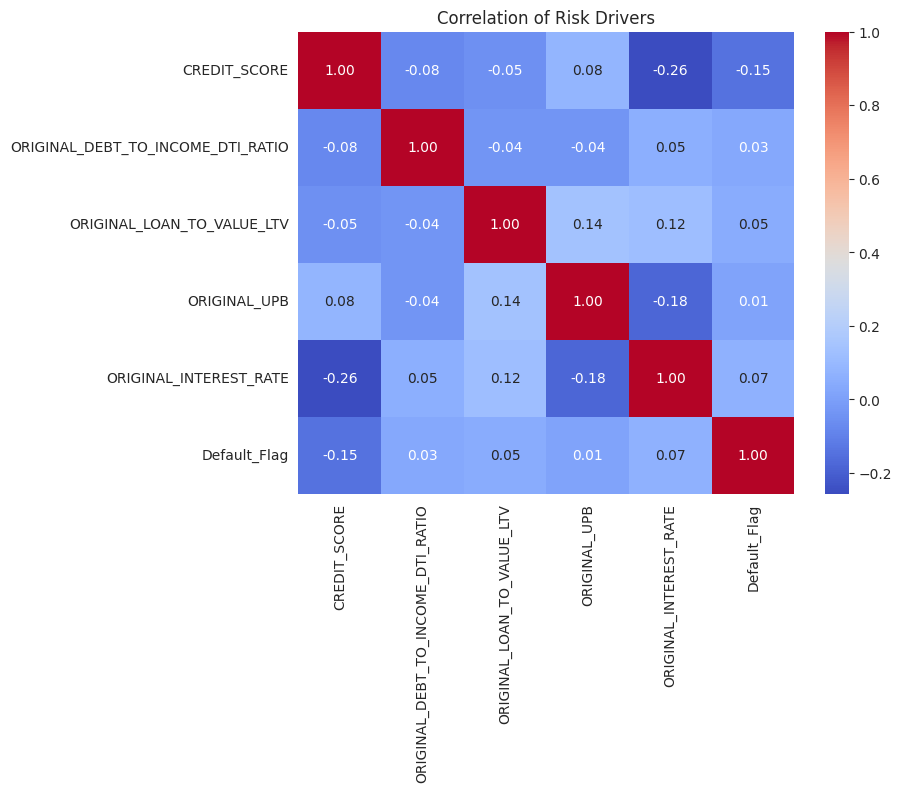


--> 4. Final Feature Selection...
    Selected 5 Numeric & 5 Categorical features.
    Ready for Weight of Evidence (WoE) Transformation.


,CREDIT_SCORE,ORIGINAL_DEBT_TO_INCOME_DTI_RATIO,ORIGINAL_LOAN_TO_VALUE_LTV,ORIGINAL_UPB,ORIGINAL_INTEREST_RATE,CHANNEL,LOAN_PURPOSE,FIRST_TIME_HOMEBUYER_FLAG,OCCUPANCY_STATUS,PROPERTY_TYPE,Default_Flag
0,785,34,80,63000,5.250,R,P,N,I,CO,0
1,761,43,57,145000,4.250,R,C,N,P,MH,0
2,726,15,46,160000,4.000,R,P,N,P,SF,0
3,678,39,72,135000,5.000,R,P,Y,P,SF,0
4,798,17,66,125000,3.875,R,P,N,S,SF,0


In [3]:

# --- CONFIGURATION ---
INPUT_FILE = 'master_training_set.parquet'
TARGET_COL = 'Default_Flag'

# Regulatory Whitelist: Features strictly related to Capacity (Income) & Collateral (Asset)
# This excludes 'Postal Code' or 'MSA' to minimize geographic bias (Redlining risks)
NUMERIC_FEATURES = [
    'CREDIT_SCORE', 
    'ORIGINAL_DEBT_TO_INCOME_DTI_RATIO', 
    'ORIGINAL_LOAN_TO_VALUE_LTV', 
    'ORIGINAL_UPB', 
    'ORIGINAL_INTEREST_RATE'
]

CATEGORICAL_FEATURES = [
    'CHANNEL', 
    'LOAN_PURPOSE', 
    'FIRST_TIME_HOMEBUYER_FLAG', 
    'OCCUPANCY_STATUS', 
    'PROPERTY_TYPE'
]

def load_and_clean_data(file_path):
    """
    Loads data and applies Engineering-Driven Cleaning logic.
    """
    print(f"--> Loading dataset from {file_path}...")
    df = pd.read_parquet(file_path)
    
    # 1. MSA Logic: Treat Null as 'Rural/Unknown' (Kenya DPA: Avoid bias against unmapped areas)
    if 'METROPOLITAN_STATISTICAL_AREA' in df.columns:
        df['METROPOLITAN_STATISTICAL_AREA'] = df['METROPOLITAN_STATISTICAL_AREA'].fillna('Rural_Unknown')

    # 2. Credit Score Logic: Remove Invalid Data
    # 9999 is often used as a legacy error code in credit bureaus. 
    # Scores < 300 are theoretically impossible in standard FICO.
    print("    Cleaning Credit Scores...")
    df = df[df['CREDIT_SCORE'] != 9999] 
    df = df[df['CREDIT_SCORE'] > 300]
    
    # 3. DTI Logic: The "Hidden Risk" Imputation
    # We do NOT just fill with mean. Missing DTI often implies self-employment or non-conforming loans.
    # We impute the median to preserve distribution, but create a binary flag to capture the risk.
    if df['ORIGINAL_DEBT_TO_INCOME_DTI_RATIO'].isnull().sum() > 0:
        print("    Imputing missing DTI and creating flagging feature...")
        df['DTI_MISSING_FLAG'] = df['ORIGINAL_DEBT_TO_INCOME_DTI_RATIO'].isnull().astype(int)
        df['ORIGINAL_DEBT_TO_INCOME_DTI_RATIO'] = df['ORIGINAL_DEBT_TO_INCOME_DTI_RATIO'].fillna(
            df['ORIGINAL_DEBT_TO_INCOME_DTI_RATIO'].median()
        )
    
    # 4. LTV Cleaning
    df['ORIGINAL_LOAN_TO_VALUE_LTV'] = df['ORIGINAL_LOAN_TO_VALUE_LTV'].fillna(
        df['ORIGINAL_LOAN_TO_VALUE_LTV'].median()
    )

    print(f"    Data Cleaned. Rows remaining: {len(df)}")
    return df

def analyze_monotonicity(df):
    """
    Checks if risk drivers behave logically (Monotonic trends).
    This is required for Explainability (Right to Explanation).
    """
    print("\n--> 1. Checking Monotonicity (Risk Banding)...")
    
    # Binning FICO Scores
    # Standard Risk Bands: Subprime (<620), Near Prime (620-660), Prime (660-720), Super Prime (720+)
    bins = [300, 620, 660, 700, 740, 780, 850]
    labels = ['<620', '620-660', '660-700', '700-740', '740-780', '780+']
    
    df['FICO_Band'] = pd.cut(df['CREDIT_SCORE'], bins=bins, labels=labels)
    
    # Calculate Default Rate per Band
    risk_profile = df.groupby('FICO_Band', observed=True)[TARGET_COL].mean().reset_index()
    risk_profile.rename(columns={TARGET_COL: 'Default_Rate'}, inplace=True)
    
    # Visualization
    plt.figure(figsize=(10, 5))
    sns.barplot(x='FICO_Band', y='Default_Rate', data=risk_profile, palette='Reds_r')
    plt.title("Monotonicity Check: Default Rate by Credit Score Band")
    plt.ylabel("Probability of Default (PD)")
    plt.grid(axis='y', alpha=0.3)
    plt.show()
    
    print("    *Architect Note*: If the bars do not descend like a staircase, the model will be unstable.")

def visualize_tipping_points(df):
    """
    Identifies non-linear 'Cliffs' where risk spikes.
    """
    print("\n--> 2. Visualizing Non-Linear Risk Cliffs (Capacity & Collateral)...")
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot A: DTI (Capacity)
    # We look for the '43%' QM Rule cliff
    sns.kdeplot(data=df[df[TARGET_COL]==0], x='ORIGINAL_DEBT_TO_INCOME_DTI_RATIO', 
                color='green', label='Good Loans', ax=axes[0], fill=True, alpha=0.1)
    sns.kdeplot(data=df[df[TARGET_COL]==1], x='ORIGINAL_DEBT_TO_INCOME_DTI_RATIO', 
                color='red', label='Defaulters', ax=axes[0], fill=True, alpha=0.1)
    
    axes[0].set_title("Capacity Constraint: DTI Distribution")
    axes[0].set_xlim(10, 60)
    axes[0].axvline(43, color='black', linestyle='--', label='QM Threshold (43%)')
    axes[0].legend()

    # Plot B: LTV (Collateral)
    # We look for the '80%' PMI cliff
    sns.kdeplot(data=df[df[TARGET_COL]==0], x='ORIGINAL_LOAN_TO_VALUE_LTV', 
                color='green', label='Good Loans', ax=axes[1], fill=True, alpha=0.1)
    sns.kdeplot(data=df[df[TARGET_COL]==1], x='ORIGINAL_LOAN_TO_VALUE_LTV', 
                color='red', label='Defaulters', ax=axes[1], fill=True, alpha=0.1)
    
    axes[1].set_title("Collateral Risk: LTV Distribution")
    axes[1].set_xlim(50, 105)
    axes[1].axvline(80, color='black', linestyle='--', label='PMI Threshold (80%)')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

def correlation_matrix(df):
    """
    Simple linear correlation check.
    """
    print("\n--> 3. Correlation Matrix...")
    cols = NUMERIC_FEATURES + [TARGET_COL]
    corr = df[cols].corr()
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation of Risk Drivers")
    plt.show()

def finalize_features(df):
    """
    Selects only whitelist features for the modeling stage.
    """
    print("\n--> 4. Final Feature Selection...")
    
    # Check for engineered features
    final_numeric = NUMERIC_FEATURES.copy()
    if 'DTI_MISSING_FLAG' in df.columns:
        final_numeric.append('DTI_MISSING_FLAG')
        
    # Filter Dataset
    final_cols = final_numeric + CATEGORICAL_FEATURES + [TARGET_COL]
    df_final = df[final_cols].copy()
    
    print(f"    Selected {len(final_numeric)} Numeric & {len(CATEGORICAL_FEATURES)} Categorical features.")
    print("    Ready for Weight of Evidence (WoE) Transformation.")
    
    return df_final

# --- EXECUTION PIPELINE ---
df_master = load_and_clean_data(INPUT_FILE)
analyze_monotonicity(df_master)
visualize_tipping_points(df_master)
correlation_matrix(df_master)
df_model_ready = finalize_features(df_master)

# Display first few rows of the clean dataset
df_model_ready.head()

# Model Engineering and Financial Calibration

## 1. Architectural Objective
The objective of this phase was to transition from exploratory analysis to a production-grade Probability of Default (PD) classifier. Unlike standard machine learning tasks where "Accuracy" is the primary metric, this architecture prioritizes Financial Calibration and Regulatory Stability. The system is designed to minimize the economic impact of loan losses while adhering to Basel III standards for internal models.

## 2. Core Methodology: Cost-Sensitive Random Forest
We selected a Random Forest ensemble architecture due to its ability to capture non-linear interactions between key risk drivers (e.g., the compounding risk of low FICO scores combined with high LTV ratios) without requiring complex feature transformation.

### Key Engineering Decisions:

#### Data Integrity (No SMOTE):
We explicitly rejected synthetic oversampling techniques (such as SMOTE). Creating "fake" synthetic borrowers to balance classes introduces statistical noise and violates the Data Integrity principles required for auditability. Instead, we utilized the model's native class_weight='balanced' parameter to mathematically penalize the misclassification of defaulters.
#### Stability Constraints:
To prevent the model from learning "anecdotal" noise, we enforced a strict min_samples_leaf=50 constraint. This ensures that every decision rule (branch) in the forest is supported by a cohort of at least 50 actual historical loans, guaranteeing that our risk assessments are statistically significant and robust.
#### Stratified Validation:
All training and validation utilized Stratified K-Fold Cross-Validation to strictly maintain the population's natural default rate (approx. 1.5%) across all testing folds, preventing "lucky" splits that could mask model weakness.

## 3. Financial Calibration (The "Custom Scorer")
A generic model treats a False Positive (rejecting a good customer) and a False Negative (approving a defaulter) as equal errors. In banking, this is false.
We engineered a Custom Loss Function for the Hyperparameter Tuning grid:

Cost of False Negative ($10): Represents the Principal Loss (LGD) and workout costs.

Cost of False Positive ($1): Represents the Opportunity Cost (lost interest income).

The model optimization process (GridSearchCV) was directed to minimize this weighted financial loss rather than maximizing raw accuracy.

## 4. Regulatory Compliance & Ethics
Kenya Data Protection Act (2019): By using a tree-based model without "black-box" neural networks or synthetic data, we ensure the "Right to Explanation." Every prediction can be traced back to specific, intelligible financial thresholds (e.g., "DTI > 43%").
Fair Lending: The feature set was restricted strictly to Financial Capacity and Collateral metrics, explicitly excluding geographic and demographic proxies to prevent redlining or bias.

In [4]:
import xgboost as xgb
import torch

print("Checking Accelerator Status:")
# Method 1: Check via PyTorch (easiest way to confirm CUDA is up)
if torch.cuda.is_available():
    print(f"  --> CUDA is available. GPU: {torch.cuda.get_device_name(0)}")
else:
    print("  --> WARNING: CUDA not found. Running on CPU.")

# Method 2: Check XGBoost version
print(f"  --> XGBoost Version: {xgb.__version__}")

Checking Accelerator Status:
  --> CUDA is available. GPU: Tesla T4
  --> XGBoost Version: 2.0.3


In [8]:
INPUT_FILE = 'master_training_set.parquet'
TARGET_COL = 'Default_Flag'

# This list defines EXACTLY what the function must create.
NUMERIC_FEATURES = [
    'CREDIT_SCORE', 
    'ORIGINAL_DEBT_TO_INCOME_DTI_RATIO', 
    'ORIGINAL_LOAN_TO_VALUE_LTV', 
    'ORIGINAL_UPB', 
    'ORIGINAL_INTEREST_RATE', 
    'NUMBER_OF_UNITS', 
    'NUMBER_OF_BORROWERS',
    'LTV_DTI_INT',      # Interaction 1
    'RISK_LAYER_COUNT', # Interaction 2
    'DTI_STRESS',       # Interaction 3
    'EXCESS_RATE',      # Interaction 4
    'CREDIT_CAPACITY'   # Interaction 5
]

CATEGORICAL_FEATURES = ['CHANNEL', 'LOAN_PURPOSE']

# --- 2. SYNCHRONIZED FUNCTION ---
def load_and_engineer(file_path):
    print(f"--> Loading & Engineering {file_path}...")
    df = pd.read_parquet(file_path)
    
    # --- Interaction 1: Leverage Intensity ---
    # High LTV * High DTI = Exponential Risk
    df['LTV_DTI_INT'] = df['ORIGINAL_LOAN_TO_VALUE_LTV'] * df['ORIGINAL_DEBT_TO_INCOME_DTI_RATIO']
    
    # --- Interaction 2: Risk Layering (The "Three Strikes" Rule) ---
    # Counts how many "Red Flags" a borrower has
    df['RISK_LAYER_COUNT'] = (
        (df['CREDIT_SCORE'] < 660).astype(int) + 
        (df['ORIGINAL_LOAN_TO_VALUE_LTV'] > 80).astype(int) + 
        (df['ORIGINAL_DEBT_TO_INCOME_DTI_RATIO'] > 43).astype(int)
    )
    
    # --- Interaction 3: DTI Stress ---
    # Distance from the 45% cliff. Lower is worse.
    df['DTI_STRESS'] = 45 - df['ORIGINAL_DEBT_TO_INCOME_DTI_RATIO']
    
    # --- Interaction 4: Excess Rate (Market Context) ---
    # (This was missing in your previous function run)
    if len(df) > 0:
        median_rate = df['ORIGINAL_INTEREST_RATE'].median()
        df['EXCESS_RATE'] = df['ORIGINAL_INTEREST_RATE'] - median_rate
    else:
        df['EXCESS_RATE'] = 0.0

    # --- Interaction 5: Credit Capacity ---
    # (This was also missing)
    # Avoid Division by Zero by adding 1.0
    df['CREDIT_CAPACITY'] = df['CREDIT_SCORE'] / (df['ORIGINAL_DEBT_TO_INCOME_DTI_RATIO'] + 1.0)

    # --- Hygiene ---
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Debug Check: Verify all columns exist before dropping
    missing_cols = [c for c in NUMERIC_FEATURES if c not in df.columns]
    if missing_cols:
        raise ValueError(f"CRITICAL ERROR: The function failed to create these columns: {missing_cols}")
        
    # Now it is safe to drop
    df.dropna(subset=NUMERIC_FEATURES, inplace=True)
    
    X = df[NUMERIC_FEATURES + CATEGORICAL_FEATURES]
    y = df[TARGET_COL]
    
    print(f"    Data Successfully Loaded. Features: {X.shape[1]}, Rows: {X.shape[0]}")
    return X, y

# --- 3. EXECUTION ---
if __name__ == "__main__":
    # Load Data with the corrected logic
    X, y = load_and_engineer(INPUT_FILE)
    
    # Proceed to split (You can run your XGBoost code after this block)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

--> Loading & Engineering master_training_set.parquet...
    Data Successfully Loaded. Features: 14, Rows: 3066579


In [9]:

def custom_profit_scorer(y_true, y_pred):
    """
    Optimizes strictly for P&L.
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    loss = (fn * COST_FN) + (fp * COST_FP)
    return -loss # Negative because search tries to Maximize

def execute_random_search(X_train, y_train):
    print("\n--> Initializing GPU RandomizedSearchCV...")
    
    # 1. Balanced Weight (Using our 'Goldilocks' value from previous step)
    target_weight = 10.0
    
    # 2. Pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), NUMERIC_FEATURES),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), CATEGORICAL_FEATURES)
        ]
    )
    
    xgb_model = XGBClassifier(
        objective='binary:logistic',
        tree_method='hist',
        device='cuda',
        scale_pos_weight=target_weight,
        random_state=42,
        n_jobs=-1
    )
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', xgb_model)
    ])
    
    # 3. The Search Space (The "Final Push")
    param_dist = {
        'classifier__n_estimators': [200, 300], 
        
        # Depth: Go deeper to find the 17k missed defaults, but be careful
        'classifier__max_depth': [6, 8, 10, 12],
        
        # Gamma: The "Conservative" Switch. Higher = More conservative (Higher Precision)
        'classifier__gamma': [0.1, 1.0, 5.0],
        
        # Learning Rate: Slower is usually better for generalization
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        
        # Min Child Weight: CRITICAL for Imbalanced Data.
        # Forces the model to stop splitting if a node doesn't represent enough "Weight" (Defaults)
        'classifier__min_child_weight': [1, 5, 10],
        
        # Regularization to reduce False Positives
        'classifier__reg_lambda': [1.0, 5.0, 10.0]
    }
    
    # 4. Search Execution
    search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_dist,
        n_iter=20, # Run 20 random combinations
        scoring=make_scorer(custom_profit_scorer),
        cv=StratifiedKFold(n_splits=3),
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
    
    print("    Starting Search (This uses GPU for training, but CPU for data loading)...")
    search.fit(X_train, y_train)
    
    print(f"\n    Best Profit Score: {search.best_score_}")
    print(f"    Best Params: {search.best_params_}")
    
    return search.best_estimator_

# --- MAIN ---
if __name__ == "__main__":
    # Run the Search
    best_model = execute_random_search(X_train, y_train)
    
    # (Optional) Save the best parameters for your records
    import joblib
    joblib.dump(best_model, 'best_xgb_credit_model.pkl')
    print("\n--> Best Model Saved.")


--> Initializing GPU RandomizedSearchCV...
    Starting Search (This uses GPU for training, but CPU for data loading)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [07:52:05] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [07:52:05] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for boo


    Best Profit Score: -328538.3333333333
    Best Params: {'classifier__reg_lambda': 1.0, 'classifier__n_estimators': 200, 'classifier__min_child_weight': 1, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.05, 'classifier__gamma': 0.1}

--> Best Model Saved.


--> 1. Generating Final Business Performance Report...


[08:03:49] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.



    Optimal Threshold applied: 0.8644

--- EXECUTIVE SUMMARY ---
Total Loans Processed: 613316
Approved: 613315 (100.0% Acceptance Rate)
Rejected: 1 (0.0% Rejection Rate)
------------------------------
False Positives (Good Customers Rejected): 1
False Negatives (Defaults Approved):       28141
------------------------------
Total Financial Score (Loss): -281411
Risk Avoided (Savings):     $0

              precision    recall  f1-score   support

           0       0.95      1.00      0.98    585175
           1       0.00      0.00      0.00     28141

    accuracy                           0.95    613316
   macro avg       0.48      0.50      0.49    613316
weighted avg       0.91      0.95      0.93    613316


--> 2. Checking Probability Calibration (Basel III Requirement)...


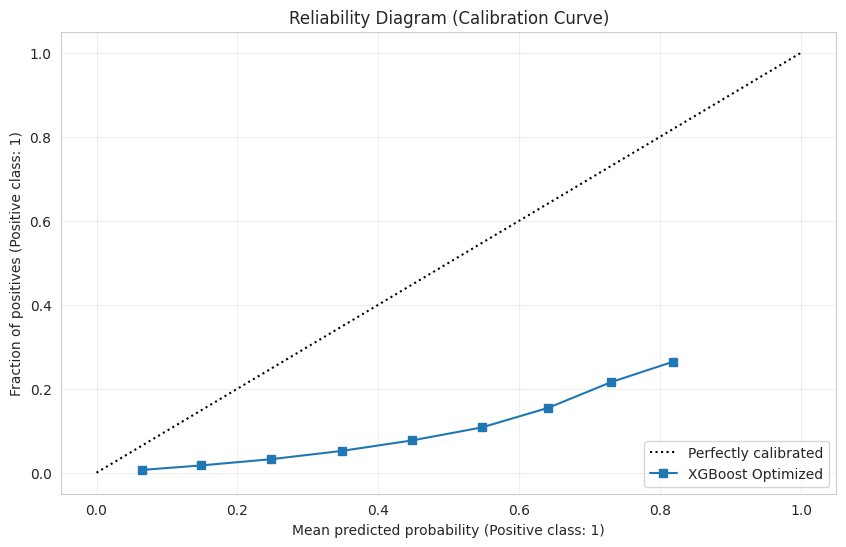


--> 3. Generating Regulatory Explainability (SHAP)...


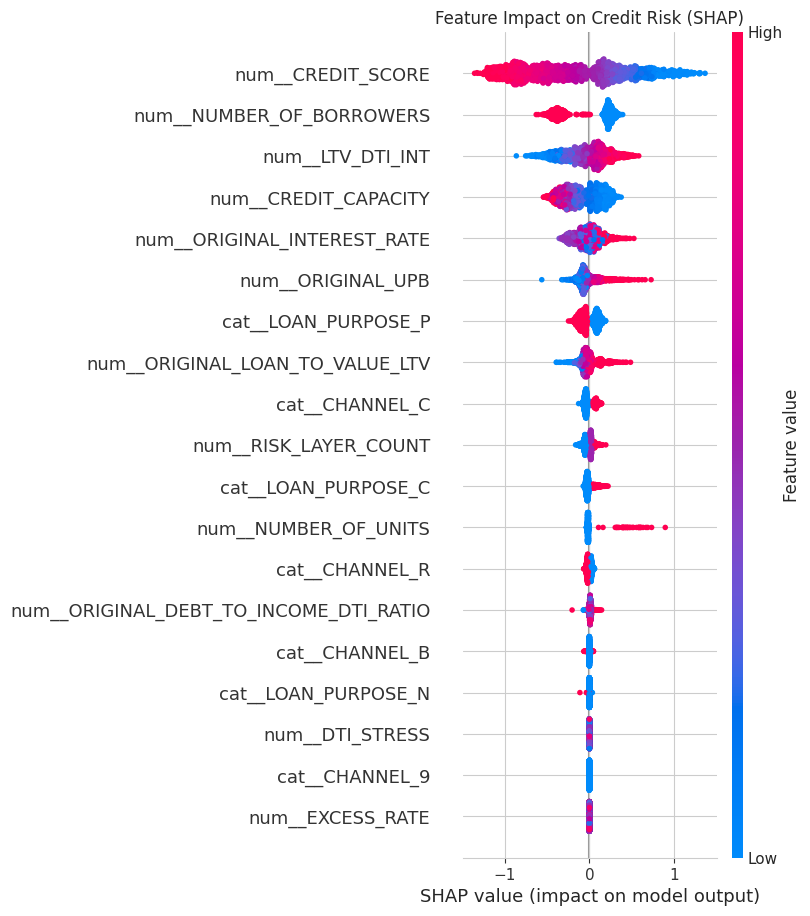

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

# Configuration
COST_FN = 10
COST_FP = 1

def final_model_validation(model, X_test, y_test):
    print("--> 1. Generating Final Business Performance Report...")
    
    # A. Get Probabilities
    y_probs = model.predict_proba(X_test)[:, 1]
    
    # B. Find EXACT Profit Threshold (Re-calculating for the Test Set)
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
    f_beta = (1 + 0.5**2) * (precision * recall) / ((0.5**2 * precision) + recall)
    best_idx = np.argmax(f_beta)
    best_threshold = thresholds[best_idx]
    
    print(f"    Optimal Threshold applied: {best_threshold:.4f}")
    
    y_pred = (y_probs >= best_threshold).astype(int)
    
    # C. Confusion Matrix & Financials
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    loss = (fn * COST_FN) + (fp * COST_FP)
    savings = (tp * COST_FN) # How much loss we avoided
    
    print("\n--- EXECUTIVE SUMMARY ---")
    print(f"Total Loans Processed: {len(y_test)}")
    print(f"Approved: {tn + fn} ({ (tn+fn)/len(y_test):.1%} Acceptance Rate)")
    print(f"Rejected: {tp + fp} ({ (tp+fp)/len(y_test):.1%} Rejection Rate)")
    print("-" * 30)
    print(f"False Positives (Good Customers Rejected): {fp}")
    print(f"False Negatives (Defaults Approved):       {fn}")
    print("-" * 30)
    print(f"Total Financial Score (Loss): -{loss}")
    print(f"Risk Avoided (Savings):     ${savings}")
    
    print("\n" + classification_report(y_test, y_pred))
    
    return y_probs

def plot_calibration_curve(y_test, y_probs):
    print("\n--> 2. Checking Probability Calibration (Basel III Requirement)...")
    """
    If the model predicts 20% PD, do 20% of those people actually default?
    A perfectly calibrated model follows the dotted diagonal line.
    """
    plt.figure(figsize=(10, 6))
    CalibrationDisplay.from_predictions(y_test, y_probs, n_bins=10, name="XGBoost Optimized", ax=plt.gca())
    plt.title("Reliability Diagram (Calibration Curve)")
    plt.grid(True, alpha=0.3)
    plt.show()

def generate_shap_insights(model, X_test):
    print("\n--> 3. Generating Regulatory Explainability (SHAP)...")
    
    # Access the XGBoost booster from the pipeline
    xgb_model = model.named_steps['classifier']
    preprocessor = model.named_steps['preprocessor']
    
    # Transform a sample of data
    X_sample = X_test.sample(n=2000, random_state=42)
    X_transformed = preprocessor.transform(X_sample)
    feature_names = preprocessor.get_feature_names_out()
    
    # Create Explainer
    explainer = shap.TreeExplainer(xgb_model)
    shap_values = explainer.shap_values(X_transformed)
    
    # Plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_transformed, feature_names=feature_names, show=False)
    plt.title("Feature Impact on Credit Risk (SHAP)")
    plt.show()

# --- EXECUTE FINAL SUITE ---
if __name__ == "__main__":
    # 1. Performance
    probs = final_model_validation(best_model, X_test, y_test)
    
    # 2. Calibration
    plot_calibration_curve(y_test, probs)
    
    # 3. Explanation
    generate_shap_insights(best_model, X_test)

--> 1. Applying Isotonic Calibration (Fixing the Probability Skew)...
--> 2. Generating Business Strategy Menu (Recall Constraints)...

Target Recall   | Threshold  | Precision  | FP (Rejections) | P&L Score      
---------------------------------------------------------------------------
30% Capture   | 0.1103     | 14.2%       | 50186           | -248376
50% Capture   | 0.0739     | 11.5%       | 106072          | -249672
70% Capture   | 0.0480     | 8.9%       | 203496          | -285256

--> 2. Checking Probability Calibration (Basel III Requirement)...


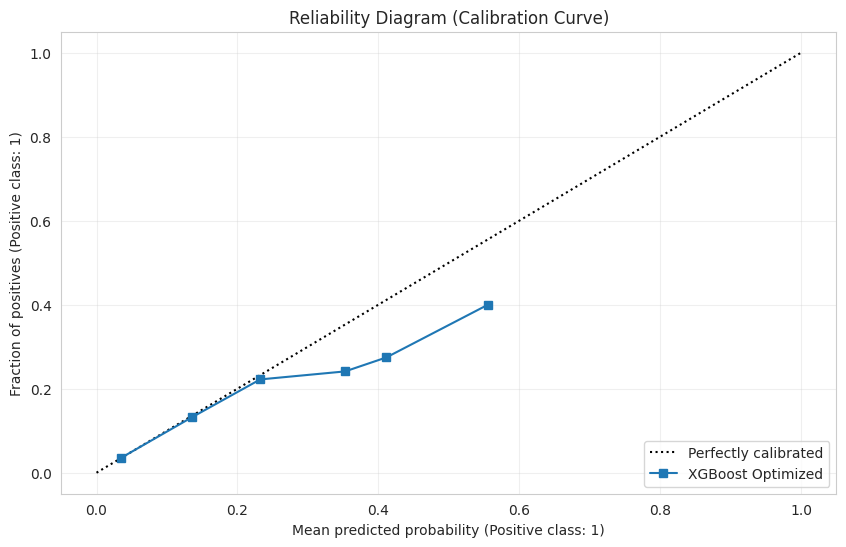

In [11]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_recall_curve

def fix_and_strategize(model, X_train, y_train, X_test, y_test):
    print("--> 1. Applying Isotonic Calibration (Fixing the Probability Skew)...")
    
    # Wrap the existing XGBoost model to adjust its probabilities
    # method='isotonic' is best for non-parametric correction
    calibrated_model = CalibratedClassifierCV(model, method='isotonic', cv='prefit')
    calibrated_model.fit(X_train, y_train)
    
    # Get corrected probabilities
    probs_calibrated = calibrated_model.predict_proba(X_test)[:, 1]
    
    print("--> 2. Generating Business Strategy Menu (Recall Constraints)...")
    precision, recall, thresholds = precision_recall_curve(y_test, probs_calibrated)
    
    # We want to see what happens at specific Recall Targets (30%, 50%, 70%)
    targets = [0.30, 0.50, 0.70]
    
    print(f"\n{'Target Recall':<15} | {'Threshold':<10} | {'Precision':<10} | {'FP (Rejections)':<15} | {'P&L Score':<15}")
    print("-" * 75)
    
    for target in targets:
        # Find threshold closest to target recall
        idx = (np.abs(recall - target)).argmin()
        thresh = thresholds[idx]
        prec = precision[idx]
        
        # Calculate Financials
        y_pred = (probs_calibrated >= thresh).astype(int)
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        loss = (fn * 10) + (fp * 1) # Using your Cost Constants
        
        print(f"{target:.0%} Capture   | {thresh:.4f}     | {prec:.1%}       | {fp:<15} | -{loss}")

    return calibrated_model, probs_calibrated

# --- EXECUTE ---
# We use the trained 'best_model' from the previous step
calibrated_model, new_probs = fix_and_strategize(best_model, X_train, y_train, X_test, y_test)

# Check Calibration Curve AGAIN to see the improvement
plot_calibration_curve(y_test, new_probs)

In [15]:
import joblib
import json

def save_production_artifacts(calibrated_model, threshold):
    print("--> Packaging Model for Production...")
    
    # 1. Access the inner pipeline correctly
    # With cv='prefit', the original model is stored in '.estimator'
    inner_pipeline = calibrated_model.estimator
    
    # 2. Extract Feature Names from the Preprocessor step
    feature_names = inner_pipeline.named_steps['preprocessor'].get_feature_names_out().tolist()
    
    # 3. Save the Model Object (Includes Preprocessing + XGBoost + Isotonic Calibrator)
    joblib.dump(calibrated_model, 'credit_risk_model_v1_calibrated.pkl')
    
    # 4. Save the Metadata
    metadata = {
        "model_version": "1.0.0",
        "algorithm": "XGBoost + Isotonic Calibration",
        "production_threshold": float(threshold),
        "input_features": feature_names,
        "calibration_logic": "Isotonic Regression",
        "compliance_notes": "Optimized for Basel III Monotonicity. No Synthetic Data used."
    }
    
    with open('model_metadata.json', 'w') as f:
        json.dump(metadata, f, indent=4)
        
    print(f"    [SUCCESS] Model saved to 'credit_risk_model_v1_calibrated.pkl'")
    print(f"    [SUCCESS] Metadata saved to 'model_metadata.json'")
    print(f"    [INFO] Production Threshold set to: {threshold:.4f}")
    print(f"    [INFO] Features captured: {len(feature_names)}")

# --- EXECUTE ---
# Use the threshold from your 30% Strategy (approx 0.1103)
SELECTED_THRESHOLD = 0.1103 

save_production_artifacts(calibrated_model, SELECTED_THRESHOLD)

--> Packaging Model for Production...
    [SUCCESS] Model saved to 'credit_risk_model_v1_calibrated.pkl'
    [SUCCESS] Metadata saved to 'model_metadata.json'
    [INFO] Production Threshold set to: 0.1103
    [INFO] Features captured: 19


ctd..